# Decoding most likely sequence

This notebooks shows how to decode the most likely sequence of symbols from the input given some constraints. 
These constraints are formulated here as a grammar. The lexicon itself may be used as some form of a constraint.

In [ ]:
from fst import *

# Define grammar

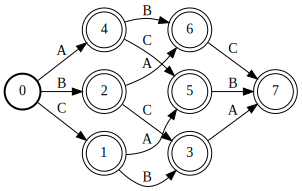

In [63]:
def wfst_grammar(phrases):
    a = Acceptor(semiring='tropical')
    
    for p in phrases:
        p = p.split()
        
        a = a.union(linear_chain(p, a.isyms))
        
    a.remove_epsilon()
    a = a.determinize()
    a.minimize()
    a.top_sort()
    
    return a

G = wfst_grammar([
"A",
"B",
"C",
"A B",
"A C",
"B A",
"B C",
"C A",
"C B",
"A C B",
"A B C",
"B A C",
"B C A",
"C A B",
"C B A",
])
    
G

# Define lexicon

Here, the entries in the lexicon are defined in such way that the longer is the word the higher probaility it has (lower cost).

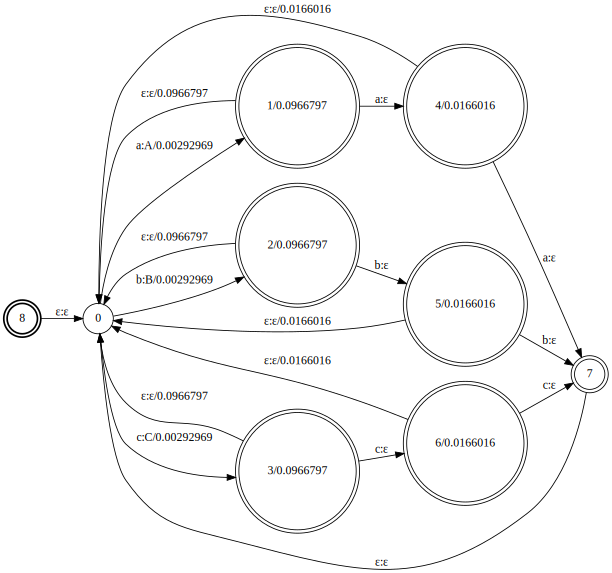

In [69]:
def wfst_lexicon(lexicon, syms, letter_weight=0.1):
    t = Transducer(osyms=syms)
    eid = 0
    for word, form in lexicon:
        if form:
            label = word
            weight = letter_weight**len(form)
            if len(form) == 1:
                t.add_arc(0, eid+1, form[0], label, weight)
                eid += 1
            elif len(form) == 2:
                t.add_arc(0, eid+1, form[0], label, weight)
                eid += 1
                t.add_arc(eid, eid+1, form[0], EPSILON, weight)
                eid += 1
            else:  
                t.add_arc(0, eid+1, form[0], label, weight)
                eid += 1
                for l in form[1:-1]:
                    t.add_arc(eid, eid + 1, l, EPSILON, weight)
                    eid += 1
                t.add_arc(eid, eid + 1, l, EPSILON, weight)
                eid += 1
            
            t[eid].final = True
        
    t.remove_epsilon()
    t = t.determinize()
    t.minimize()
    t = t.closure()

    t.top_sort()
    
    return t

L = wfst_lexicon([
    ('A', 'a'),
    ('A', 'aa'),
    ('A', 'aaa'),
    ('B', 'b'),
    ('B', 'bb'),
    ('B', 'bbb'),
    ('C', 'c'),
    ('C', 'cc'),
    ('C', 'ccc'),
], G.isyms)

L

# Compose LG

In [70]:
L.arc_sort_output()
G.arc_sort_input()

LG = L.compose(G)
LG.top_sort()
LG = LG.determinize()
LG.minimize()
LG.remove_epsilon()

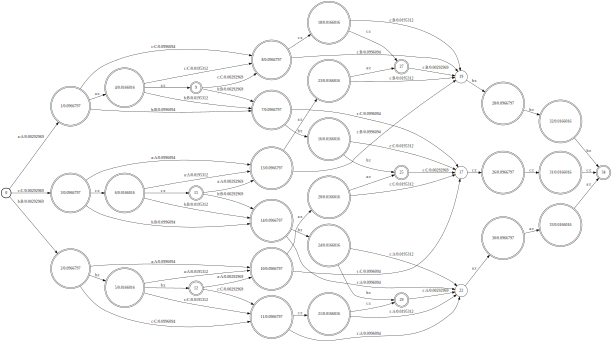

In [71]:
LG

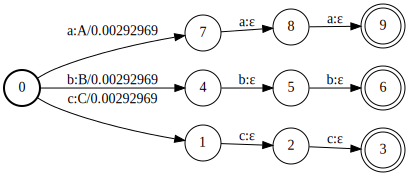

In [72]:
sp = LG.shortest_path(3)
sp.remove_epsilon()
sp.top_sort()
sp

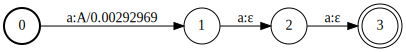

In [73]:
sp = LG.shortest_path()
sp.remove_epsilon()
sp.top_sort()
sp

# Define input

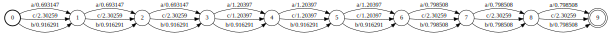

In [84]:
from math import log

def sum_weigths(t):
    return sum([float(arc.weight) for state in sp.states for arc in state.arcs])

def wfsa_from_sausage(sousage, syms):
    a = Acceptor(syms=syms, semiring='tropical')

    for i, d in enumerate(sousage):
        for l, w in d.items():
            a.add_arc(i, i + 1, l, -log(w))

    a[i+1].final = True
    
    a.top_sort()
    
    return a

I = wfsa_from_sausage([
    {'a': .5, 'b': 0.4, 'c': 0.1},
    {'a': .5, 'b': 0.4, 'c': 0.1},
    {'a': .5, 'b': 0.4, 'c': 0.1},
    {'a': .3, 'b': 0.4, 'c': 0.3},
    {'a': .3, 'b': 0.4, 'c': 0.3},
    {'a': .3, 'b': 0.4, 'c': 0.3},
    {'a': .45, 'b': 0.45, 'c': 0.1},
    {'a': .45, 'b': 0.45, 'c': 0.1},
    {'a': .45, 'b': 0.45, 'c': 0.1},
], L.isyms)

I

# Compose ILG

Here, we are actually doing decoding.

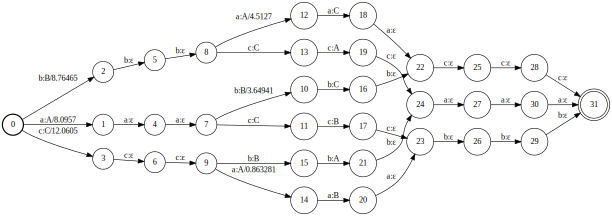

In [89]:
I.arc_sort_output()
LG.arc_sort_input()

ILG = I.compose(LG)
ILG.top_sort()
ILG = ILG.determinize()
ILG.minimize()
ILG.remove_epsilon()

ILG

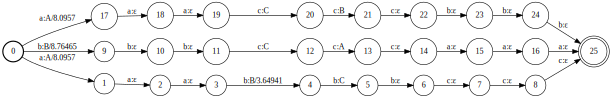

In [90]:
sp = ILG.shortest_path(3)
sp.remove_epsilon()
sp.top_sort()
sp

In [ ]:
# The shortest (the most likely) path

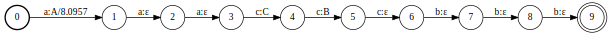

In [87]:
sp = ILG.shortest_path()
sp.remove_epsilon()
sp.top_sort()
sp

Please note that we decoded sequence "aaacccbbb" which is not the most likely sequnce without using LG. Please below the most likely sequence of the original input I.

In [88]:
sp = I.shortest_path()
sp.remove_epsilon()
sp.top_sort()
sp

Here is the sequence "aaabbbccc" which expected given the parameters of the input I (sausage).  